# Chapter 3 
## Data Ingestion and Preprocessing

One way to improve our RAG system is to improve our data ingestion and preprocessing.

In [1]:
import json
import os
import pathlib
from datetime import datetime
from typing import Dict, List

import dotenv
import numpy as np
import wandb
import cohere
import requests
import markdown
import re
from bs4 import BeautifulSoup


dotenv.load_dotenv()

True

In [2]:
WANDB_ENTITY = "rag-course"
WANDB_PROJECT = "dev"

wandb.require("core")

run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    group="Chapter 3",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: parambharat (rag-course). Use `wandb login --relogin` to force relogin


In [3]:
# We'll re-use the raw dataset from the artifact in our previous step


raw_artifact = run.use_artifact(
    f"{WANDB_ENTITY}/{WANDB_PROJECT}/raw_data:latest", type="dataset"
)
artifact_dir = raw_artifact.download()
raw_data_file = pathlib.Path(f"{artifact_dir}/documents.jsonl")
raw_data = list(map(json.loads, raw_data_file.read_text().splitlines()))
raw_data[:2]

2024/07/04 17:13:57 [DEBUG] GET https://storage.googleapis.com/wandb-production.appspot.com/rag-course/dev/0z2t11h3/artifact/936065098/wandb_manifest.json?Expires=1720097037&GoogleAccessId=gorilla-files-url-signer-man%40wandb-production.iam.gserviceaccount.com&Signature=bMktGRSkJcXb%2FxWpQNSLbiBv%2FfFsE1Xsw9LoOOjcFOSAbD9CxakPgMDgvgZTsU4cGXHVceERXsqfOzLfeA%2BI5JPB7aWo4V9IZakLrPjFBMs1ueRNCoiLSNE5sikvnVA9Dw%2FNdGzlSRyjtYRVBsknElgIbT7dvJxo1dlrx%2FLIs%2B1P0wsjOaWFHXqThg3yIFJfWrUwB%2FKdaG%2B6OaxPhevCekX6Nc9jGGjAWZL3pn0vgjkzgTYcuJfHN1r9YbnmkHqIuL09%2BJrOJ3P4AQAacecnv5KDa1eR4swnBa84OcVFroVE%2FxgbSGWa19ttzCu4HGkGB62979dTz6v%2F4Z5VLm%2F2Bg%3D%3D


[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

In [4]:
# Earlier we referred to words as tokens. We can be more correct in defining tokens by using a tokenizer.
# We'll use the Cohere tokenizer for this example.

co = cohere.Client(api_key=os.environ["CO_API_KEY"])

In [5]:
def tokenize_text(text: str) -> List[str]:
    return co.tokenize(text=text, model="command-r", offline=True)

In [6]:
tokenizers = {
    "command-r": "https://storage.googleapis.com/cohere-public/tokenizers/command-r.json",
    "command-r-plus": "https://storage.googleapis.com/cohere-public/tokenizers/command-r-plus.json"
}


In [7]:
for doc in raw_data[:]:
    doc['metadata']['words'] = doc['metadata'].pop('raw_tokens')
    doc['metadata']['tokens'] = len(tokenize_text(doc['content']).tokens)
raw_data[:2]

[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

## Pre-processing

There is a lot of extra formatting information (markdown elements) that is not very useful to an LLM.

We can remove this information by converting the contents to text. We can also remove any special characters and extra whitespace. 

Special characters here are ones that are defined in the tokenizer and will vary depending on the model used.


In [8]:
import frontmatter

def convert_contents_to_text(contents: str) -> str:
    _, content = frontmatter.parse(contents)
    # use some extensions to convert the markdown to html
    markdown_document = markdown.markdown(
        content,
        extensions=[
            "toc",
            "pymdownx.extra",
            "pymdownx.blocks.admonition",
            "pymdownx.magiclink",
            "pymdownx.blocks.tab",
            "pymdownx.pathconverter",
            "pymdownx.saneheaders",
            "pymdownx.striphtml",
            "pymdownx.highlight",
            "pymdownx.pathconverter",
            "pymdownx.escapeall"
        ],
    )
    soup = BeautifulSoup(markdown_document, "html.parser")
    def remove_urls_a_tags_hrefs(soup):
        # For hyperlinks, keep the text but remove the link
        for a_tag in soup.find_all('a'):
            a_tag.replace_with(a_tag.text)
        
        # Remove all images
        for img_tag in soup.find_all('img'):
            img_tag.decompose()
        
        # Remove all href attributes (this is now redundant for <a> tags, but keeps other elements clean)
        # for tag in soup.find_all(href=True):
        #     del tag['href']
        
        return soup

    # Use the function as before
    soup = remove_urls_a_tags_hrefs(soup)

    def remove_javascript_import_statements(soup):
        for p in soup.find_all('p'):
            if p.text.strip().startswith('import') and ';' in p.text:
                p.decompose()
        return soup
    soup = remove_javascript_import_statements(soup)

    return soup.get_text()

def get_special_tokens_set(tokenizer_url):
    # https://docs.cohere.com/docs/tokens-and-tokenizers
    response = requests.get(tokenizer_url)
    return set([tok["content"] for tok in response.json()["added_tokens"]])

special_tokens_set = get_special_tokens_set(tokenizers["command-r"])
def make_text_tokenization_safe(content: str, special_tokens_set: set=special_tokens_set) -> str:
    
    # Normalize newlines and replace multiple new lines with a single new line
    # content = re.sub(r'\n+', '\n', content, flags=re.UNICODE)
    

    def remove_special_tokens(text: str) -> str:
        """Removes special tokens from the given text.

        Args:
            text: A string representing the text.

        Returns:
            The text with special tokens removed.
        """
        for token in special_tokens_set:
            text = text.replace(token, "")
        return text

    cleaned_content = remove_special_tokens(content)
    return cleaned_content

In [9]:
parsed_data = []

for doc in raw_data:
    parsed_doc = doc.copy()
    content = convert_contents_to_text(doc["content"])
    parsed_doc["parsed_content"] = make_text_tokenization_safe(content)
    parsed_doc["metadata"]["parsed_tokens"] = len(tokenize_text(parsed_doc["parsed_content"]).tokens)
    parsed_data.append(parsed_doc)
parsed_data[:2]

[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

In [10]:
total_words = sum(map(lambda x: x["metadata"]["words"], parsed_data))
total_raw_tokens = sum(map(lambda x: x["metadata"]["tokens"], raw_data))
total_parsed_tokens = sum(map(lambda x: x["metadata"]["parsed_tokens"], parsed_data))

preprocessed_artifact = wandb.Artifact(name="preprocessed_data", type="dataset",
description="Preprocessed wandb documentation", metadata={
    "total_files": len(parsed_data),
    "date_preprocessed": datetime.now().strftime("%Y-%m-%d"),
    "total_words": total_words,
    "total_raw_tokens": total_raw_tokens,
    "total_parsed_tokens": total_parsed_tokens,
    }
)
with preprocessed_artifact.new_file("documents.jsonl", mode="w") as f:
    for item in parsed_data:
        f.write(json.dumps(item) + "\n")
run.log_artifact(preprocessed_artifact)

<Artifact preprocessed_data>

## Data Chunking

1. First we split the text into sentences using [BlingFire](https://github.com/microsoft/BlingFire) library.
2. Then we split the sentences into chunks of a maximum number of tokens.

In [16]:
from blingfire import text_to_sentences

In [17]:
preprocessed_artifact = run.use_artifact(f'{WANDB_ENTITY}/{WANDB_PROJECT}/preprocessed_data:latest', type='dataset')
artifact_dir = preprocessed_artifact.download()
preprocessed_data_file = pathlib.Path(f"{artifact_dir}/documents.jsonl")
preprocessed_data = list(map(json.loads, preprocessed_data_file.read_text().splitlines()))
preprocessed_data[:2]

2024/07/04 17:14:40 [DEBUG] GET https://storage.googleapis.com/wandb-production.appspot.com/rag-course/dev/bn5dpiph/artifact/943357119/wandb_manifest.json?Expires=1720097080&GoogleAccessId=gorilla-files-url-signer-man%40wandb-production.iam.gserviceaccount.com&Signature=fkAYjmFYdY%2BVBvA9r0eI6i%2B7kgpMpdYwzrTLUVvgDXFPyVm9jQxEl3xNp%2FkxpSK1dIe%2FXVU6CvS%2FsJzMUdEMGXK90Y6wF5RaBNE2P9wuuiP%2B%2FgKmin6PGYERMY6TZTARpFv%2Bwe8Rc35oU2nuLwlmzQQoLZ7I%2FzMwNE6lMRS3kkHQoN%2BdR09GpLM4AkhFDpMhgkc2TKngAqs75wq1JNsXE88J5LDPx%2F2FMtuUjIdvyWuB%2Blmp6yZMLOWIqbVvFHQMk1XBMgDUEHu%2Fpl5HZ6pxuaMlMMxhHrytIo5vUnMzKJm8JbY%2F5ffTJvueADXgmdGs%2FxQ2y%2BTmGZ8lt9Yc6iF8OQ%3D%3D


[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

In [18]:
#ref: https://platform.openai.com/docs/tutorials/web-qa-embeddings

CHUNK_SIZE=500

# Function to split the text into chunks of a maximum number of tokens


def split_into_chunks(text, max_tokens = CHUNK_SIZE):

    # Split the text into sentences
    sentences = text_to_sentences(text).split("\n")

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenize_text("\n" + sentence).tokens) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append("\n".join(chunk))
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks

In [19]:
chunked_data = []
for doc in preprocessed_data:
    chunks = split_into_chunks(doc["parsed_content"])
    for chunk in chunks:
        chunked_data.append(
            {
                "parsed_content" : chunk,
                "metadata": {
                    "source": doc["metadata"]["source"],
                    "parsed_tokens": len(tokenize_text(chunk).tokens)
            }})
        
chunked_data[:2]

[{'parsed_content': 'Anonymous Mode Are you publishing code that you want anyone to be able to run easily?\nUse Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\nAllow results to be logged in Anonymous Mode with wandb.init(anonymous="allow") :::info Publishing a paper?\nPlease cite W&B, and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n::: How does someone without an account see results?\nIf someone runs your script and you have to set anonymous="allow":  Auto-create temporary account: W&B checks for an account that\'s already signed in.\nIf there\'s no account, we automatically create a new anonymous account and save that API key for the session.\nLog results quickly: The user can run and re-run the script, and automatically see results show up in the W&B dashboard UI.\nThese unclaimed anonymous runs will be available for 7 days.\

In [21]:
# Again, we'll store the cleaned data in an artifact for future use and reproducibility

total_cleaned_tokens = sum(map(lambda x: x["metadata"]["parsed_tokens"], chunked_data))

chunked_artifact = wandb.Artifact(
    name="chunked_data",
    type="dataset",
    description="Chunked wandb documentation",
    metadata={
        "total_files": len(chunked_data),
        "date_processed": datetime.now().strftime("%Y-%m-%d"),
        "total_raw_tokens": total_raw_tokens,
        "total_cleaned_tokens": total_cleaned_tokens,
        "chunk_size": CHUNK_SIZE,
    },
)
with chunked_artifact.new_file("documents.jsonl", mode="w") as f:
    for item in chunked_data:
        f.write(json.dumps(item) + "\n")
run.log_artifact(chunked_artifact)

<Artifact chunked_data>

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist

class Retriever:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.index = None
        self.data = None

    def index_data(self, data):
        self.data = data
        docs = [doc["parsed_content"] for doc in data]
        self.index = self.vectorizer.fit_transform(docs)

    def search(self, query, k=5):
        query_vec = self.vectorizer.transform([query])
        cosine_distances = cdist(
            query_vec.todense(), self.index.todense(), metric="cosine"
        )[0]
        top_k_indices = cosine_distances.argsort()[:k]
        output = []
        for idx in top_k_indices:
            output.append(
                {
                    "source": self.data[idx]["metadata"]["source"],
                    "text": self.data[idx]["parsed_content"],
                    "score": 1 - cosine_distances[idx],
                }
            )
        return output

In [46]:
# Let's test with a simple query


retriever = Retriever()
retriever.index_data(chunked_data)

query = "How do I use W&B to log metrics in my training script?"
search_results = retriever.search(query)
for result in search_results:
    print(result)

{'source': 'guides/technical-faq/troubleshooting.md', 'text': 'Troubleshooting If wandb crashes, will it possibly crash my training run?\nIt is extremely important to us that we never interfere with your training runs.\nWe run wandb in a separate process to make sure that if wandb somehow crashes, your training will continue to run.\nIf the internet goes out, wandb will continue to retry sending data to wandb.ai.\nWhy is a run marked crashed in W&B when it’s training fine locally?\nThis is likely a connection problem — if your server loses internet access and data stops syncing to W&B, we mark the run as crashed after a short period of retrying.\nDoes logging block my training?\n"Is the logging function lazy?\nI don\'t want to be dependent on the network to send the results to your servers and then carry on with my local operations."\nCalling wandb.log writes a line to a local file; it does not block any network calls.\nWhen you call wandb.init we launch a new process on the same machi

In [47]:
# Now we are ready to generate a response grounded on the documentation.


class ResponseGenerator:
    def __init__(self, model: str, prompt: str):
        self.client = cohere.Client(api_key=os.environ["CO_API_KEY"])
        self.model = model
        self.prompt = prompt

    # @weave.op()

    def generate_response(self, query: str, context: List[Dict[str, any]]) -> str:
        
        documents = [{"source": item['source'], "text": item['text']} for item in context]
        response = self.client.chat(
            preamble=self.prompt,
            message=query,
            model=self.model,
            documents=documents,
            temperature=0.1,
            max_tokens=2000,
        )
        return response.text

In [48]:
PROMPT = "Answer to the following question about W&B. Provide an helful and complete answer based only on the provided documents."

In [49]:
response_generator = ResponseGenerator(model="command-r", prompt=PROMPT)
answer = response_generator.generate_response(query, search_results)
print(answer)

To log metrics in your training script, you can include the following lines of code:
```
# Import the W&amp;B Python Library
import wandb

# Start a W&amp;B Run
run = wandb.init(project="cat-classification", notes="", tags=["baseline", "paper1"])

# Log metrics inside your training loop
for epoch in range(wandb.config.epochs):
 for batch in dataloader:
 loss, accuracy = model.training_step()
 wandb.log({"accuracy": accuracy, "loss": loss})
```
When you call `wandb.init() from your training script, a separate process is launched to stream and collect metrics, which keeps all threads and logic out of your primary process. Your script runs normally and writes to local files, while the separate process streams them to the W&B servers along with system metrics.

You can log metrics such as accuracy and loss during each epoch to visualize model performance. As shown in the example above, use `wandb.log()` to log the metrics inside your training loop. This will append a new step to the histor

In [50]:
class RAGPipeline:
    def __init__(self, retriever: Retriever, response_generator: ResponseGenerator, top_k: int = 5):
        self.retriever = retriever
        self.response_generator = response_generator
        self.top_k = top_k

    def __call__(self, query: str):
        context = self.retriever.search(query, self.top_k)
        return self.response_generator.generate_response(query, context)

In [56]:
rag_pipeline = RAGPipeline(retriever, response_generator, top_k=10)
response = rag_pipeline(query="Where do I find my API Key?")
print(response)

You can collect your API key by navigating to the authorize page or in your user/team settings. User/team settings can be found on the W&B App UI. Alternatively, you can run 'wandb login' on the command line and paste your API key there. Remember to store your API key securely and never share it by checking it into version control.


## Eval the changes

In [52]:
import pandas as pd

In [53]:
eval_artifact = run.use_artifact(
    f"{WANDB_ENTITY}/{WANDB_PROJECT}/eval_dataset:latest", type="dataset"
)
eval_dir = eval_artifact.download("../data/eval")
eval_dataset = pd.read_json(
    f"{eval_dir}/eval_dataset.jsonl", lines=True, orient="records"
)
eval_samples = eval_dataset.to_dict(orient="records")
eval_dataset

2024/07/04 17:27:33 [DEBUG] GET https://storage.googleapis.com/wandb-production.appspot.com/rag-course/dev/okxu0mvh/artifact/938190750/wandb_manifest.json?Expires=1720097853&GoogleAccessId=gorilla-files-url-signer-man%40wandb-production.iam.gserviceaccount.com&Signature=kV6NK3lIrKzAia43Uq%2BDA2xEsV7FrKCR5XOdA2tF2KfAdq8RPZwjXS0u1K%2BJbvdwtmC8HoPyE50MxEgHNqt%2FsloCjP6%2FSVOMW5zVYBl78jA46a%2BjcfVbBKTqhcHJ3W79Bv%2FZx8jS%2BguuJT3L63eEbLU0PPdJdefUvAll%2BIi4289DltGz96FnndUfAPpnMm4JZHFeT%2FJw3CL3L%2FZVShBfCvpQA2zHehphBT7LHDjxLeHTqM%2BLKfRKc50P22dCPgM6K3VJUManmX572ndMkamicPd5m7x%2BTsHrv00Y72pWb3B65F5bG%2FxyeJiLbMI7AH7hr3ceBiF9y77i7fwiqS0v5Q%3D%3D


,question,answer,source
0,What is the difference between `.log()` and `....,The summary is the value that shows in the tab...,guides/technical-faq/general.md
1,How do I switch between accounts on the same m...,If you have two W&B accounts working from the ...,guides/technical-faq/general.md
2,How is W&B different from TensorBoard?,"We love the TensorBoard folks, and we have a T...",guides/technical-faq/general.md
3,What is the difference between team and organi...,A team is a collaborative workspace for a grou...,guides/technical-faq/admin.md
4,What is the difference between team and entity...,A team is a collaborative workspace for a grou...,guides/technical-faq/admin.md
5,"Can I just log metrics, no code or dataset exa...","**Dataset Examples**\n\nBy default, we don't l...",guides/technical-faq/metrics-and-performance.md
6,How can I log a metric that doesn't change ove...,Using `wandb.log({'final_accuracy': 0.9}` will...,guides/technical-faq/metrics-and-performance.md
7,How many runs to create per project?,We recommend you have roughly 10k runs per pro...,guides/technical-faq/metrics-and-performance
8,Can I run wandb offline?,If you're training on an offline machine and w...,guides/technical-faq/setup.md
9,How do I deal with network issues?,If you're seeing SSL or network errors:`wandb:...,guides/technical-faq/troubleshooting.md


In [55]:
from ranx import Qrels, Run, evaluate
from typing import Any
from tqdm import tqdm

RETRIEVAL_METRICS = ["ndcg@10", "map@10", "mrr", "hit_rate", "precision", "recall", "f1"]


def evaluate_retriever(retrieved_docs: List[Dict[str, Any]], actual_doc: str) -> Dict[str, Any]:
    qrels = Qrels({"query": {actual_doc: 1}})
    run = Run({"query": {doc["source"]: doc["score"] for doc in retrieved_docs}})
    return evaluate(qrels, run, metrics=RETRIEVAL_METRICS)


retrieval_scores = []
for sample in tqdm(eval_samples):
    query = sample["question"]
    expected_source = sample["source"]
    search_results = retriever.search(query, k=10)
    eval_scores = evaluate_retriever(search_results, expected_source)
    retrieval_scores.append({"query": query, **eval_scores})

retrieval_scores_df = pd.DataFrame(retrieval_scores)
display(retrieval_scores_df)

print("\nMean Overall Retrieval Scores:")
display(pd.DataFrame(retrieval_scores_df[RETRIEVAL_METRICS].mean()).T)

print("\nOverall Retrieval Score Statistics:")
display(pd.DataFrame(retrieval_scores_df[RETRIEVAL_METRICS].describe()).T)

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


,query,ndcg@10,map@10,mrr,hit_rate,precision,recall,f1
0,What is the difference between `.log()` and `....,1.00000,1.000000,1.000000,1.0,0.111111,1.0,0.200000
1,How do I switch between accounts on the same m...,0.30103,0.111111,0.111111,1.0,0.100000,1.0,0.181818
2,How is W&B different from TensorBoard?,0.50000,0.333333,0.333333,1.0,0.142857,1.0,0.250000
3,What is the difference between team and organi...,1.00000,1.000000,1.000000,1.0,0.166667,1.0,0.285714
4,What is the difference between team and entity...,1.00000,1.000000,1.000000,1.0,0.111111,1.0,0.200000
5,"Can I just log metrics, no code or dataset exa...",1.00000,1.000000,1.000000,1.0,0.125000,1.0,0.222222
6,How can I log a metric that doesn't change ove...,1.00000,1.000000,1.000000,1.0,0.100000,1.0,0.181818
7,How many runs to create per project?,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
8,Can I run wandb offline?,0.50000,0.333333,0.333333,1.0,0.125000,1.0,0.222222
9,How do I deal with network issues?,1.00000,1.000000,1.000000,1.0,0.100000,1.0,0.181818



Mean Overall Retrieval Scores:


,ndcg@10,map@10,mrr,hit_rate,precision,recall,f1
0,0.590051,0.555556,0.555556,0.7,0.081587,0.7,0.145776



Overall Retrieval Score Statistics:


,count,mean,std,min,25%,50%,75%,max
ndcg@10,20.0,0.590051,0.451745,0.0,0.0,0.750000,1.000000,1.000000
map@10,20.0,0.555556,0.468640,0.0,0.0,0.666667,1.000000,1.000000
mrr,20.0,0.555556,0.468640,0.0,0.0,0.666667,1.000000,1.000000
hit_rate,20.0,0.700000,0.470162,0.0,0.0,1.000000,1.000000,1.000000
precision,20.0,0.081587,0.057238,0.0,0.0,0.100000,0.125000,0.166667
recall,20.0,0.700000,0.470162,0.0,0.0,1.000000,1.000000,1.000000
f1,20.0,0.145776,0.101307,0.0,0.0,0.181818,0.222222,0.285714


In [59]:

RETRIEVAL_EVAL_PROMPT ="""
Given a query and a document excerpt, you must provide a score on an integer scale of 0 to 3 with the following meanings:
    0 = represent that the excerpt has nothing to do with the query,
    1 = represents that the excerpt seems related to the query but does not help answer it,
    2 = represents that the excerpt has some answer for the query, but the answer may be a bit unclear, or hidden amongst extraneous information and
    3 = represents that the excerpt is dedicated to the query and contains the exact answer.

Important Instruction: Assign category 1 if the excerpt is somewhat related to the topic but not completely, category 2 if excerpt presents something very important related to the entire topic but also has some extra information and category 3 if the excerpt only and entirely refers to the topic. If none of the above satisfies give it category 0.

Query: {query}
Document: {document}

Split this problem into steps:
Consider the underlying intent of the query. Measure how well the content matches a likely intent of the query(M).
Measure how trustworthy the excerpt is (T).
Consider the aspects above and the relative importance of each, and decide on a final score (O). 
Final score must be an integer value only.
Do not provide any code in result. Provide each score in the following JSON format: 


{{"final_score": <integer score without providing any reasoning.>}}

"""

In [60]:
client = cohere.AsyncClient(api_key=os.environ["CO_API_KEY"])

async def evaluate_retriever_using_llm_judge(query: str, passage: str) -> int:
    response = await client.chat(
        message=RETRIEVAL_EVAL_PROMPT.format(query=query, document=passage),
        model="command-r-plus",
        temperature=0.0,
        max_tokens=2000,
    )
    return response.text


In [61]:
import nest_asyncio
nest_asyncio.apply()
import asyncio
import json

sample = eval_samples[0]
query = sample["question"]
search_results = retriever.search(query, k=5)
tasks = []
for result in search_results:
    tasks.append(evaluate_retriever_using_llm_judge(query, result["text"]))
sample_scores = asyncio.run(asyncio.gather(*tasks))
sample_scores

['{"final_score": 3}',
 '{"final_score": 3}',
 '{"final_score": 0}',
 '{"final_score": 3}',
 '{"final_score": 2}']

In [62]:
async def run_retriever_evaluation_using_llm(eval_samples):
    scores = []
    for sample in eval_samples:
        query = sample["question"]
        search_results = retriever.search(query, k=5)
        tasks = []
        for result in search_results:
            tasks.append(evaluate_retriever_using_llm_judge(query, result["text"]))
        sample_scores = await asyncio.gather(*tasks)
        sample_scores = map(json.loads, sample_scores)
        sample_scores = list(map(lambda x: x["final_score"], sample_scores))
        scores.append({"query": query, "scores": sample_scores})
    return scores
    

In [63]:
llm_judge_retrieval_results = asyncio.run(run_retriever_evaluation_using_llm(eval_samples))

In [64]:
# we have the scores for each document
llm_judge_retrieval_results_df = pd.DataFrame(llm_judge_retrieval_results)

# we can compute the reciprocal rank of the first document that is relevant to the query i.e. rated as 3 by our llm judge.
def compute_rank_score(scores: List[int]) -> float:
    rank_score = 0
    for rank, result in enumerate(scores, 1):
        if result == 3:
            rank_score = 1 / rank
            return rank_score
    return rank_score

llm_judge_retrieval_results_df["rank_score"] = llm_judge_retrieval_results_df["scores"].map(compute_rank_score)


display(llm_judge_retrieval_results_df)


print(f"Mean Rank Score: {llm_judge_retrieval_results_df['rank_score'].mean():.4f}")
print(f"Std-dev Rank Score: {llm_judge_retrieval_results_df['rank_score'].std():.4f}")


,query,scores,rank_score
0,What is the difference between `.log()` and `....,"[3, 3, 0, 3, 2]",1.000000
1,How do I switch between accounts on the same m...,"[0, 0, 1, 0, 0]",0.000000
2,How is W&B different from TensorBoard?,"[2, 2, 3, 3, 2]",0.333333
3,What is the difference between team and organi...,"[3, 1, 1, 1, 1]",1.000000
4,What is the difference between team and entity...,"[3, 1, 3, 0, 2]",1.000000
5,"Can I just log metrics, no code or dataset exa...","[3, 3, 3, 3, 3]",1.000000
6,How can I log a metric that doesn't change ove...,"[3, 3, 3, 3, 3]",1.000000
7,How many runs to create per project?,"[2, 3, 2, 2, 2]",0.500000
8,Can I run wandb offline?,"[3, 3, 3, 3, 0]",1.000000
9,How do I deal with network issues?,"[3, 2, 2, 0, 0]",1.000000


Mean Rank Score: 0.8917
Std-dev Rank Score: 0.2772


In [68]:
import difflib
import Levenshtein
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate import meteor
from nltk.tokenize import word_tokenize

# We can measure the similarity of the response to the expected answer using difflib and Levenshtein distance
# These are simple metrics.

def calculate_diff_score(candidate, reference):
    return difflib.SequenceMatcher(None, candidate, reference).ratio()


def calculate_levenshtein_score(candidate, reference):
    return Levenshtein.ratio(candidate, reference)



# semantic answer similarity. (SAS) - https://arxiv.org/abs/2108.06130
# Originally, one should use a transformer based cross-encoder to measure and classify this. 
# For example, use something from https://sbert.net/docs/cross_encoder/usage/usage.html
# we can also calculate the cosine similarity between the candidate and the reference using our retriever's vectorizer
def calculate_similarity(candidate, reference):
    vectors = retriever.vectorizer.transform([candidate, reference])
    similarity = cosine_similarity(vectors)[0][1]
    return similarity




# or we can use traditional metrics used to measure generation systems.
# ref: https://blog.paperspace.com/automated-metrics-for-evaluating-generated-text/

def calculate_rouge(candidate, reference):
    rouge = Rouge(metrics=["rouge-l"], stats="f")
    scores = rouge.get_scores(candidate, reference)
    return scores[0]["rouge-l"]["f"]


def calculate_bleu(candidate, reference):
    chencherry = SmoothingFunction()
    smoothing_function = chencherry.method2

    reference = word_tokenize(reference)
    candidate = word_tokenize(candidate)
    score = sentence_bleu([reference], candidate, smoothing_function=smoothing_function)
    return score


def calculate_meteor(candidate, reference):
    reference = word_tokenize(reference)
    candidate = word_tokenize(candidate)
    meteor_score = meteor([candidate], reference)
    return meteor_score


In [69]:
rag_pipeline = RAGPipeline(retriever, response_generator)

response_scores = []
for sample in tqdm(eval_samples):
    query = sample['question']
    actual_answer = rag_pipeline(query)
    expected_answer = sample['answer']
    diff_score = calculate_diff_score(actual_answer, expected_answer)
    levenshtein_score = calculate_levenshtein_score(actual_answer, expected_answer)
    rouge_score = calculate_rouge(actual_answer, expected_answer)
    bleu_score = calculate_bleu(actual_answer, expected_answer)
    meteor_score = calculate_meteor(actual_answer, expected_answer)
    similarity_score = calculate_similarity(actual_answer, expected_answer)

    response_scores.append({
        "query": query,
        "expected_answer": expected_answer,
        "actual_answer": actual_answer,
        "diff_score": diff_score,
        "levenshtein_score": levenshtein_score,
        "rouge_score": rouge_score,
        "bleu_score": bleu_score,
        "meteor_score": meteor_score,
        "similarity_score": similarity_score
    })

100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


In [70]:

response_scores_df = pd.DataFrame(response_scores)
display(response_scores_df)

GENERATION_METRICS = [col for col in response_scores_df.columns if "score" in col]


print("\nMean Overall Generation Scores:")
display(pd.DataFrame(response_scores_df[GENERATION_METRICS].mean()).T)

print("\nOverall Generation Score Statistics:")
display(pd.DataFrame(response_scores_df[GENERATION_METRICS].describe()).T)

,query,expected_answer,actual_answer,diff_score,levenshtein_score,rouge_score,bleu_score,meteor_score,similarity_score
0,What is the difference between `.log()` and `....,The summary is the value that shows in the tab...,The summary is the value that shows in the tab...,0.142349,0.519573,0.484375,0.273118,0.461614,0.690083
1,How do I switch between accounts on the same m...,If you have two W&B accounts working from the ...,To switch between accounts on the same machine...,0.021068,0.365688,0.196078,0.041005,0.100473,0.174637
2,How is W&B different from TensorBoard?,"We love the TensorBoard folks, and we have a T...",Here are some ways in which W&B (Weights & Bia...,0.087273,0.374876,0.300000,0.035381,0.477273,0.511543
3,What is the difference between team and organi...,A team is a collaborative workspace for a grou...,An organization is a high-level entity that ma...,0.377193,0.412281,0.606742,0.319642,0.389861,0.676034
4,What is the difference between team and entity...,A team is a collaborative workspace for a grou...,An entity refers to either a username or a tea...,0.137652,0.518219,0.495050,0.278176,0.383771,0.587536
5,"Can I just log metrics, no code or dataset exa...","**Dataset Examples**\n\nBy default, we don't l...","Yes, you can just log metrics without providin...",0.011261,0.448198,0.325203,0.078870,0.300286,0.213999
6,How can I log a metric that doesn't change ove...,Using `wandb.log({'final_accuracy': 0.9}` will...,"To log a metric that doesn't change over time,...",0.197115,0.451923,0.178571,0.201340,0.338727,0.436238
7,How many runs to create per project?,We recommend you have roughly 10k runs per pro...,There is no specific number of runs to create ...,0.152985,0.220149,0.114286,0.017058,0.026069,0.154099
8,Can I run wandb offline?,If you're training on an offline machine and w...,"Yes, you can run W&B offline. If your machine ...",0.159848,0.561370,0.421875,0.213403,0.457613,0.699943
9,How do I deal with network issues?,If you're seeing SSL or network errors:`wandb:...,"If you're experiencing network issues, such as...",0.458577,0.579079,0.551724,0.227293,0.698551,0.752566



Mean Overall Generation Scores:


,diff_score,levenshtein_score,rouge_score,bleu_score,meteor_score,similarity_score
0,0.257731,0.48763,0.425517,0.216933,0.457466,0.564691



Overall Generation Score Statistics:


,count,mean,std,min,25%,50%,75%,max
diff_score,20.0,0.257731,0.172215,0.011261,0.141175,0.222101,0.374331,0.568588
levenshtein_score,20.0,0.487630,0.130090,0.220149,0.398203,0.480832,0.581427,0.704065
rouge_score,20.0,0.425517,0.187632,0.114286,0.255556,0.459471,0.564813,0.768116
bleu_score,20.0,0.216933,0.166185,0.017058,0.069404,0.220348,0.319989,0.649195
meteor_score,20.0,0.457466,0.244370,0.026069,0.284098,0.459613,0.706758,0.830568
similarity_score,20.0,0.564691,0.238078,0.154099,0.364525,0.623098,0.728230,0.894306


In [71]:

CORRECTNESS_EVAL_PROMPT ="""
You are a Weight & Biases support expert tasked with evaluating the correctness of answers to questions asked by users to a technical support chatbot. 
You are tasked with judging the correctness of a generated answer based on the user's query, and a reference answer.

You will be given the following information:

<query>
{query}
</query>

<reference_answer>
{reference_answer}
</reference_answer>

<generated_answer>
{generated_answer}
</generated_answer>

Important Instruction: To evaluate the generated answer, follow these steps:

1. Intent Analysis: Consider the underlying intent of the query.
2. Relevance: Check if the generated answer addresses all aspects of the question.
3. Accuracy: Compare the generated answer to the reference answer for completeness and correctness.
4. Trustworthiness: Measure how trustworthy the generated answer is when compared to the reference.

Assign a score on an integer scale of 0 to 3 with the following meanings:
- 0 = The generated answer is incorrect and does not satisfy any of the criteria.
- 1 = The generated answer is partially correct, contains mistakes or is not factually correct.
- 2 = The generated answer is correct but includes some extra information, is incomplete or misses some evaluation criteria.
- 3 = The generated answer is correct, completely answers the query, does not contain any mistakes, and is factually consistent with the reference answer.

After your analysis, provide your verdict in the following JSON format:

{{
    "reason": "<<Provide a brief explanation for your decision here>>",
    "final_score": <<Provide a score as per the above guidelines>>,
    "decision": "<<Provide your final decision here, either 'correct' or 'incorrect'>>"
}}

Here are some examples of correct output:

Example 1:
{{
    "reason": "The generated answer has the exact details as the reference answer and completely answers the user's query.",
    "final_score": 3,
    "decision": "correct"
}}

Example 2:
{{
    "reason": "The generated answer doesn't match the reference answer and deviates from the user's query.",
    "final_score": 0,
    "decision": "incorrect"
}}

Example 3:
{{
    "reason": "The generated answer follows the same steps as the reference answer. However, it includes assumptions about functions that are not requested in the user's query",
    "final_score": 2,
    "decision": "correct"
}}

Example 4:
{{
    "reason": "The generated answer is incorrect, irrelevant, and not factually correct and completely misses the user's intent.",
    "final_score": 0,
    "decision": "incorrect"
}}

Please provide your evaluation based on the given information and format your response according to the specified JSON structure.
"""

In [72]:
client = cohere.AsyncClient(api_key=os.environ["CO_API_KEY"])

async def evaluate_correctness_using_llm_judge(query: str, reference_answer: str, generated_answer: str) -> int:
    response = await client.chat(
        message=CORRECTNESS_EVAL_PROMPT.format(query=query, reference_answer=reference_answer, generated_answer=generated_answer),
        model="command-r-plus",
        temperature=0.0,
        max_tokens=2000,
    )
    return response.text


In [73]:
async def run_correctness_evaluation_using_llm(response_scores):
    tasks = []
    for row in response_scores:
        query = row["query"]
        expected_answer = row["expected_answer"]
        generated_answer = row["actual_answer"]
        tasks.append(evaluate_correctness_using_llm_judge(query, expected_answer, generated_answer))
    scores = await asyncio.gather(*tasks)
    scores = list(map(json.loads, scores))
    return scores
    

In [74]:
llm_judge_correctness_results = asyncio.run(run_correctness_evaluation_using_llm(response_scores))

In [75]:
correctness_eval_df = pd.DataFrame(llm_judge_correctness_results)
response_evals_df = pd.concat([response_scores_df, correctness_eval_df], axis=1)
response_evals_df

,query,expected_answer,actual_answer,diff_score,levenshtein_score,rouge_score,bleu_score,meteor_score,similarity_score,reason,final_score,decision
0,What is the difference between `.log()` and `....,The summary is the value that shows in the tab...,The summary is the value that shows in the tab...,0.142349,0.519573,0.484375,0.273118,0.461614,0.690083,The generated answer addresses the user's quer...,3,correct
1,How do I switch between accounts on the same m...,If you have two W&B accounts working from the ...,To switch between accounts on the same machine...,0.021068,0.365688,0.196078,0.041005,0.100473,0.174637,The generated answer does not address the user...,0,incorrect
2,How is W&B different from TensorBoard?,"We love the TensorBoard folks, and we have a T...",Here are some ways in which W&B (Weights & Bia...,0.087273,0.374876,0.300000,0.035381,0.477273,0.511543,The generated answer addresses the user's quer...,3,correct
3,What is the difference between team and organi...,A team is a collaborative workspace for a grou...,An organization is a high-level entity that ma...,0.377193,0.412281,0.606742,0.319642,0.389861,0.676034,The generated answer correctly explains the di...,3,correct
4,What is the difference between team and entity...,A team is a collaborative workspace for a grou...,An entity refers to either a username or a tea...,0.137652,0.518219,0.495050,0.278176,0.383771,0.587536,The generated answer correctly explains the di...,3,correct
5,"Can I just log metrics, no code or dataset exa...","**Dataset Examples**\n\nBy default, we don't l...","Yes, you can just log metrics without providin...",0.011261,0.448198,0.325203,0.078870,0.300286,0.213999,The generated answer correctly addresses the u...,3,correct
6,How can I log a metric that doesn't change ove...,Using `wandb.log({'final_accuracy': 0.9}` will...,"To log a metric that doesn't change over time,...",0.197115,0.451923,0.178571,0.201340,0.338727,0.436238,The generated answer provides the correct code...,3,correct
7,How many runs to create per project?,We recommend you have roughly 10k runs per pro...,There is no specific number of runs to create ...,0.152985,0.220149,0.114286,0.017058,0.026069,0.154099,The generated answer addresses the user's quer...,2,correct
8,Can I run wandb offline?,If you're training on an offline machine and w...,"Yes, you can run W&B offline. If your machine ...",0.159848,0.561370,0.421875,0.213403,0.457613,0.699943,The generated answer correctly states that W&B...,2,correct
9,How do I deal with network issues?,If you're seeing SSL or network errors:`wandb:...,"If you're experiencing network issues, such as...",0.458577,0.579079,0.551724,0.227293,0.698551,0.752566,The generated answer addresses the user's quer...,2,correct


LLM Judge Response Accuracy: 0.9000


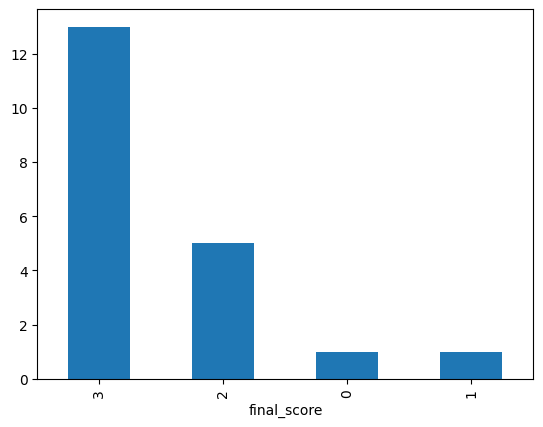

In [84]:
llm_judge_response_accuracy = (response_evals_df["decision"] == "correct").sum()/len(response_evals_df)
print(f"LLM Judge Response Accuracy: {llm_judge_response_accuracy:.4f}")
response_evals_df['final_score'].value_counts().plot(kind="bar");